# **Chapter X: Distributed Computing with cuPyNumeric**

## **Introduction:**

cuPyNumeric is a NumPy-compatible library designed for large-scale computing. It aims to provide a distributed and accelerated drop-in replacement for the NumPy API. The library is a part of an ongoing project known as Legate which leverages the data-centric programming model, Legion to provide scalable/accessible alternatives to Python by utilizing GPU acceleration and distributed computing. cuPyNumeric aspires to replace the widely used Python library,  NumPy. The goal of Legate and libraries similar to cuPyNumeric is to democratize high-performance computing allowing programmers to harness the power of large CPU and GPU clusters, while still being able to run that same code on a desktop or laptop seamlessly\! 

**cuPyNumeric vs NumPy:**

cuPyNumeric is designed to have all the features that NumPy has, making it very easy for NumPy users to come over and use cuPyNumeric. However, there are several key differences:

* Scalability: cuPyNumeric has the ability to run on large CPU/GPU clusters, making it better suited for larger data processing as the world is constantly evolving with the help of AI.  
* GPU Acceleration: As cuPyNumeric leverages GPU acceleration, it allows for significant performance improvements over NumPy, which is limited to CPU-bound operations. cuPyNumeric makes it significantly easier to tackle large quantities of datasets.  
* Distributed Computing: cuPyNumeric supports distributed computing, allowing for computations to be spread across various nodes, which enables users to handle increasing problem sizes more efficiently, significantly reducing the total computation time compared to using NumPy alone.

## **Hardware Requirements:**

Suggested requirements (single-node setup):

* GPUs: Nvidia V100 or later  
* CPUs: AMD EPYC, Intel Xeon (with multi-core support, at least 16 cores)  
* System memory: 64 GB or more (depends on dataset size)

Other options:  Works on HPC clusters like Perlmutter\! ([Perlmutter](https://docs.nersc.gov/systems/perlmutter/architecture/) is a powerful supercomputer located at the National Energy Research Scientific Computing Center (NERSC))

## **Basic installation on local machines and clusters:**

To download CUDA on your Linux server, follow these steps:

1. Go to [CUDA Toolkit Downloads](https://developer.nvidia.com/cuda-downloads).  
2. Select your operating system, architecture, distribution, and version.  
3. Choose the installer type (e.g., runfile or deb).  
4. Follow the provided installation instructions specific to your selected options.

To install Conda on your Linux machine, paste the following commands into your terminal:

In [ ]:
mkdir -p ~/miniforge3 
wget https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh -O ~/miniforge3/miniforge.sh
bash ~/miniforge3/miniforge.sh -b -u -p ~/miniforge3 
rm -rf ~/miniforge3/miniforge.sh 
~/miniforge3/bin/conda init bash
~/miniforge3/bin/conda init zsh
source ~/.bashrc

Installation for different OS systems: [Conda](https://docs.anaconda.com/miniconda/)

Following that let’s install Legate and cuPyNumeric by entering the following commands into the terminal as well:

In [ ]:
conda create -n legate -c conda-forge -c legate cupynumeric

conda activate legate

**Installation on Perlmutter (example of GASNet-based installation, for Cray clusters):**

Create an interactive session:

In [ ]:
salloc --nodes 1 --qos interactive --time 01:30:00 --constraint gpu_ss11 --gpus 2 --account=<group-id> --mem=200G

The above command creates an interactive session, with 1 node, 2 A100s (gpu_ss11), 200GB of memory, and runtime of 1 hour and 30 mins.

In [ ]:
conda create -n legate -c conda-forge -c legate/label/gex-experimental cupynumeric realm-gex-wrapper legate-mpi-wrapper

If any dependencies need updating, please go ahead and update them as well.

In [ ]:
conda activate legate

To use multi-node, activate the wrappers below:

In [ ]:
/global/homes/<intial>/<username>/miniconda3/envs/legate/gex-wrapper/build-gex-wrapper.sh

/global/homes/<intial>/<username>/miniconda3/envs/legate/mpi-wrapper/build-gex-wrapper.sh

Re-run conda activate legate if the environment needs to be activated again.



###  **Sample run:**

Create a file, main.py, and enter the following code: 

In [ ]:
import cupynumeric as np
from legate.timing import time
# Define the size of the vectors
start_time = time()
size = 100000000 

# Generate two random vectors of the specified size
vector1 = np.random.rand(size)
vector2 = np.random.rand(size)

# Compute the dot product using cuPyNumeric
dot_product = np.dot(vector1, vector2)

# Print the result
end_time = time()
elapsed_time = (end_time - start_time)/1000

print("Dot product:", dot_product)
print(f"Dot product took {elapsed_time:.4f} ms")

To run the code you follow this structure: `legate <legate CLI options> ./main.py <main.py options>`.
For example let's use:

In [ ]:
legate --gpus 4 --sysmem 2000 --fbmem 12000 ./main.py 


Output:

In [ ]:
Sample Output:

Dot product: 25000794.032157946
Dot product took 75.4890 ms

Note that Legate will by default use most of the hardware resources (e.g. CPU cores, RAM and GPUs) available on the current machine.
In the rest of the tutorial we will assume that automatic configuration has been turned off, so we can showcase the effect of incrementally passing more resources to Legate.
This can be done with `export LEGATE_AUTO_CONFIG=0`.

# **Simple Matrix Multiplication:**

## **Introduction:**

Matrix Multiplication is a basic operation where to two matrices are combined to produce a new matrix. The new matrix has elements that were computed as the sum of the products of the corresponding rows of the first matrix and the columns of the second matrix. When scaling MM, multiple factors like load balancing and parallelization must be considered. As the work is distributed amongst the different devices, handling partial sums for the matrices becomes crucial which may require reduction on a larger scale. When using cuPyNumeric, all of these fundamental aspects are handled by the library, and the user can focus on the high-level operation.

If users, didn’t use cuPyNumeric, they would have to worry about different things like distributing inputs, gathering, and synchronization while writing up the code. Down below is an image depicting the typical sort of scatter-gather method found in data parallelism.

*(**Disclaimer**: The image below does not depict cuPyNumeric's approach to parallelism. It only illustrates how parallelism might be approached without using cuPyNumeric.)*	

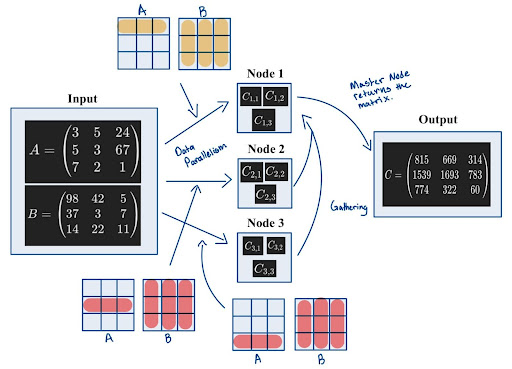

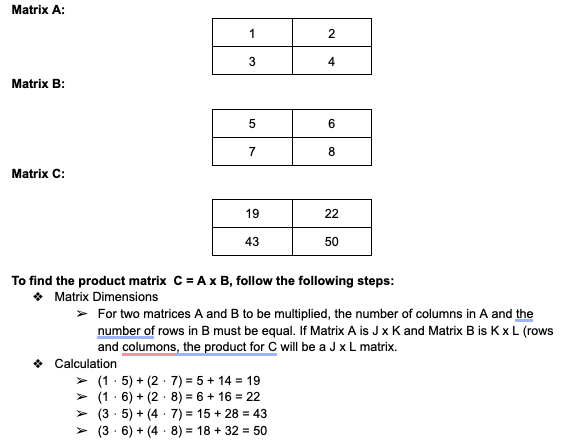

## **Running on CPU:**

**NumPy**:

Create a new file for our matrix multiplication, simply name it simple\_mm.py, and insert this piece of code. 
The following code uses NumPy

In [ ]:
from legate.timing import time
import numpy as np
start_time = time()
size = 10000 
A = np.random.randn(size,size)
B = np.random.randn(size,size)
C = np.matmul(A,B)
end_time = time()
elapsed_time = (end_time - start_time)/1000
print(f"Problem size: {size}")
print(f"Matrix multiplication took {elapsed_time:.4f} ms")

**cuPyNumeric**:

To simply use cuPyNumeric change the code to this:

In [ ]:
from legate.timing import time

#The change is down below
import cupynumeric as np
start_time = time()
size = 10000 
A = np.random.randn(size,size)
B = np.random.randn(size,size)
C = np.matmul(A,B)
end_time = time()
elapsed_time = (end_time - start_time)/1000
print(f"Problem size: {size}")
print(f"Matrix multiplication took {elapsed_time:.4f} ms")

In order to run the following file, run the command down below,

In [ ]:
legate --cpus 1 --sysmem 8000 ./simple_mm.py

Output:

In [ ]:
Problem size: 10000
Matrix multiplication took 69664.2020 ms

## **Running on GPU:**

In [ ]:
from legate.timing import time
import cupynumeric as np
start_time = time()
size = 10000 
A = np.random.randn(size,size)
B = np.random.randn(size,size)
C = np.matmul(A,B)
end_time = time()
elapsed_time = (end_time - start_time)/1000
print(f"Problem size: {size}")
print(f"Matrix multiplication took {elapsed_time:.4f} ms")

This time around we will increase the size of the problem to 20,000, and use one GPU! (must edit the file to 

In [ ]:
legate --gpus 1 --sysmem 2000 --fbmem 12000 ./simple_mm.py

Output:

In [ ]:
Problem size: 20000
Matrix multiplication took 2593.2960 ms

For the rest of this section, experiments will be conducted on Perlmutter, a HPC

Now let's use ***2 gpus (1 node)*** to solve a bigger problem, the problem size this time around will be ***40,000***\! (Ran on Perlmutter)

In [ ]:
legate --gpus 2 --sysmem 2000 --fbmem 24000 ./simple_mm.py

Output:

In [ ]:
Problem size: 40000
Matrix multiplication took 4291.7860 ms

Now let's use ***4 gpus (1 node)*** to solve a bigger problem, the problem size this time around will be **70*,000***\! (Ran on Perlmutter)

In [ ]:
legate --gpus 4 --sysmem 2000 --fbmem 38000 ./simple_mm.py

Output:

In [ ]:
Problem size: 70000
Matrix multiplication took 11771.6360 ms

Now let's use ***8 gpus (2 node)*** to solve a bigger problem, the problem size this time around will be **100*,000***\! (Ran on Perlmutter) ***(need to finish)***

#  **Conjugate Gradient:**

## **Introduction:** 

The Conjugate Gradient (CG) method is an iterative algorithm that is utilized to solve systems of linear equations of the form: 

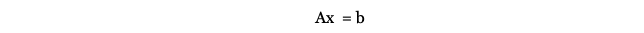

“A” is a symmetric positive-definite matrix, “x” is an unknown vector that we want to solve for, and “b” is a known vector

CG iteratively improves the estimate for x by optimizing along conjugate directions. This process minimizes the following quadratic function, which is at its minimum when x solves Ax \= b:



Below is an image of how to parallelize CG using Task parallelism. Task parallelism occurs when different tasks are executed across multiple nodes/processors/cores. 

(***Disclaimer**: The image below does not depict cuPyNumeric's approach to parallelism. It only illustrates how parallelism might be approached without using cuPyNumeric.)*	

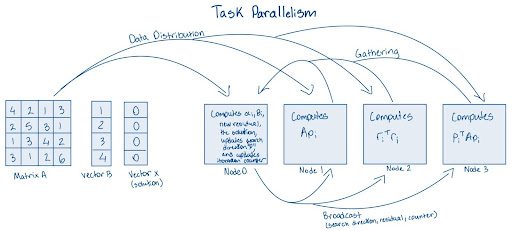

When parallelizing the Conjugate Gradient method on high-performance computing (HPC) systems, several critical factors must be addressed. First and foremost in task parallelism, it is important to distribute the tasks correctly, as improper partitioning can lead to load imbalances during computations. Clearly, in this depiction,  distributing the tasks correctly is challenging and can significantly reduce efficiency. As such, finding an effective distribution strategy can be difficult at times. Additionally, synchronization is crucial, as nodes may require information from one another before they can execute their calculations. For instance, at the beginning of each iteration, synchronization ensures that all nodes have the most up-to-date data and are aligned in their computations. Furthermore, effective broadcasting of data is essential; nodes may need to access results computed by the master node to proceed with their respective tasks. Addressing these factors will significantly enhance the efficiency and scalability of the parallelized Conjugate Gradient method. 

These challenges highlight the complexities of parallelizing the CG method without advanced libraries. However, utilizing cuPyNumeric can alleviate many of these concerns, as it provides optimized data structures and operations that inherently address issues of load balancing, communication efficiency, and synchronization. cuPyNumeric streamlines the parallelization process, allowing for more straightforward implementation and improved performance.

## **Example:**

Let’s consider a very basic 2x2 system of linear equations:

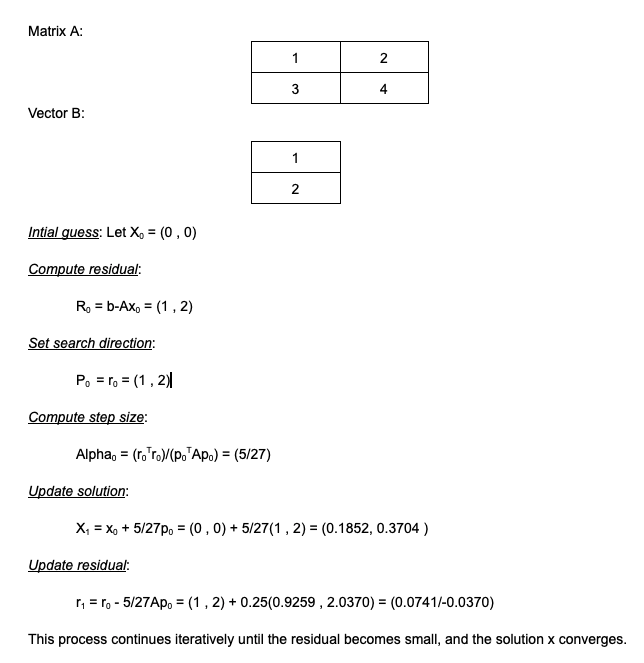

## **Running on CPU:**

Create a new file for our CG code, simply name it cg.py, and insert this piece of code:

[CG Code](https://github.com/nv-legate/cupynumeric/blob/branch-24.11/examples/cg.py)

Additionally, create another file with this piece of code in the same directory:

[Benchmark](https://github.com/nv-legate/cupynumeric/blob/branch-24.11/examples/benchmark.py)

In order to run the following file, run the command down below, this will be a 10,000 x 10,000 2-d adjacency system.

In [ ]:
legate --cpus 1 --sysmem 16000 ./cg.py --num 100 --check --time

Output:

In [ ]:
Generating 10000x10000 2-D adjacency system without corners...
Solving system...
Converged in 500 iterations
Checking result...
PASS!
Elapsed Time: 30639.848 ms

## **Running on GPU:**

This time around we will ***increase*** the size of the problem to generate roughly a  22,500 by 22,500 2-d adjacency system, and use one GPU\! 

In [ ]:
legate --gpus 1 --sysmem 48000 --fbmem 14000 ./cg.py --num 150 --check --time

Output:

In [ ]:
Generating 22500x22500 2-D adjacency system without corners...
Solving system...
Converged in 725 iterations
Checking result...
PASS!
Elapsed Time: 5384.21 ms

Now let's use ***2 GPUs (1 node)*** to solve a bigger problem, the size of the problem will be a **50625 x 50625** 2-d adjacency system\!

In [ ]:
legate --gpus 2 --sysmem 40000 --fbmem 38000 ./cg.py --num 225 --check --time

Output:

In [ ]:
Generating 50625 x 50625 2-D adjacency system without corners...
Solving system...
Converged in 1100 iterations
Checking result...
PASS!
Elapsed Time: 11432.713 ms

Now let's use ***4  GPUs (1 node)*** to solve a bigger problem, the size of the problem will be a **75625 x 75625** 2-d adjacency system\!

In [ ]:
legate --gpus 4 --sysmem 40000 --fbmem 38000 ./cg.py --num 275 --check --time

Output:

In [ ]:
Generating 75625 x 75625 2-D adjacency system without corners...
Solving system...
Converged in 1100 iterations
Checking result...
PASS!
Elapsed Time: 14832.497 ms

# **Black-Scholes:**

## **Introduction:** 

The Black-Scheoles is a mathematical model developed by economists Fisher Black, Myron Scholes, and Rober Merton in the early 1970s. The model is used to calculate the theoretical price of options.

    Formulas:

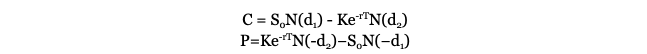

	Where: 

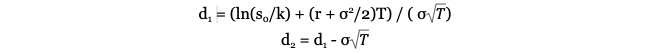


N(x) is the cumulative distribution function of the standard normal distribuation

* Current Stock Price (S0​): The price of the stock at the time of option pricing.  
* Strike Price (K): The price at which the option can be exercised.  
* Risk-Free Rate (r): The theoretical return on an investment with no risk, often based on government bonds.  
* Time to Expiration (T): How long until the option expires, measured in years.  
* Volatility (σ): The degree of variation in the stock price; higher volatility increases option prices.

In this illustration, we demonstrate how the Black-Scholes model is used to compute call and put option prices for 10,000 options distributed across four worker nodes. Each node is responsible for processing a portion of the total calculations, allowing for efficient parallel computation. Once the calculations are complete, the results are collected and aggregated at a master node.

**Note:** While this diagram depicts the results being stored in arrays, the actual code implementation does not explicitly store the results in this manner. Instead, the pricing outcomes are computed but may not be gathered into an array format as shown here.

(***Disclaimer**: The image below does not depict cuPyNumeric's approach to parallelism. It only illustrates how parallelism might be approached without using cuPyNumeric.)*	 

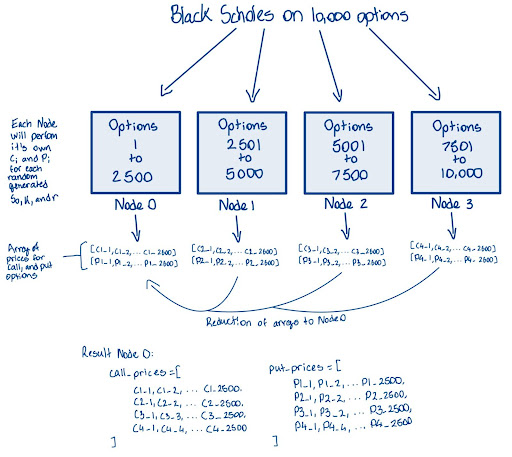

When parallelizing the Black-Scholes algorithm, several key considerations come into play. The independent nature of the algorithm for each option calculation makes it inherently suitable for parallelization; however, careful management of shared resources is essential to maximize efficiency. Effective memory management is particularly critical when dealing with large datasets of options, as it helps prevent bottlenecks and enhances performance across all nodes. Furthermore, the master node must synchronize with the worker nodes to ensure that all computations are completed before moving on to the aggregation phase. This synchronization can introduce latency, making it imperative to manage it efficiently to minimize delays in overall processing time. Another crucial aspect is the reduction of the calculated option prices into separate arrays for call and put options, which must be aggregated back to node 0\. Properly implementing this reduction process is vital for ensuring the accuracy and integrity of the final results, while still leveraging the advantages of parallelization. Balancing these considerations will contribute to a more effective and efficient parallel execution of the Black-Scholes algorithm.

cuPyNumeric improves the parallelization of the Black-Scholes algorithm by streamlining the management of parallel computing challenges. It automatically distributes independent option calculations across multiple processors or cores, ensuring optimal load distribution with ease.

## **Example:**

Let's calculate the price of a call option using the Black-Scholes model.  
Given:

* Current stock price (S0​) \= $50  
* Strike price (K) \= $50  
* Time to expiration (T) \= 1 year  
* Risk-free interest rate (r) \= 5% or 0.05  
* Volatility (σ) \= 20% or 0.20

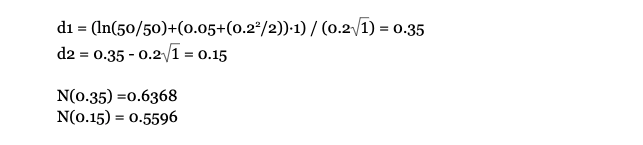

Call option price:

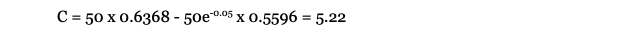

This answer is the price of a call option, similarly,  you can do the same for the put option

## **Running on CPU:**

Create a new file for our Black-Scholes code, simply name it black-scholes.py, and insert this piece of code:

[Black-Scholes Code](https://github.com/nv-legate/cupynumeric/blob/branch-24.11/examples/black_scholes.py)

Additionally, create another file with this piece of code in the same directory:

[Benchmark](https://github.com/nv-legate/cupynumeric/blob/branch-24.11/examples/benchmark.py)

In order to run the following file, run the command down below, this will perform the Black-Scholes algorithm on a set of **10,000,000** options

In [ ]:
legate --cpus 1 --sysmem 10000 ./black_scholes.py --num 10000 --precision 32 --time

Output:

In [ ]:
Running black scholes on 10000K options...
Elapsed Time: 993.466 ms

## **Running on GPU:**

This time around we will ***increase*** the size of the problem with **100,000,000** options:

In [ ]:
legate --gpus 1 --sysmem 10000 --fbmem 14000  ./black_scholes.py --num 100000 --precision 32 --time

Output:

In [ ]:
Running black scholes on 100000K options...
Elapsed Time: 2193.961 ms

Now let's use ***2 GPUs (1 node)*** to solve a bigger problem with **1,000,000,000** options:

In [ ]:
legate --gpus 2 --sysmem 10000 --fbmem 38000  ./black_scholes.py --num 1000000 --precision 32 --time

Output:

In [ ]:
Running black scholes on 1000000K options...
Elapsed Time: 1202.919 ms

Now let's use ***4 GPUs (1 node)*** to solve a bigger problem with **2,000,000,000** options:

In [ ]:
legate --gpus 4 --sysmem 10000 --fbmem 38000  ./black_scholes.py --num 2000000 --precision 32 --time

Output:

In [ ]:
Running black scholes on 2000000K options...
Elapsed Time: 1241.457 ms

# **Jacobi stencil:**

## **Introduction:** 

The Jacobi stencil is a method used to solve systems of linear or partial differential equations. The technique works by repeatedly taking the averages of the neighboring points to update the value at each grid location. This method is often used along slide problems like heat diffusion.

Formula:



(***Disclaimer**: The image below does not depict cuPyNumeric's approach to parallelism. It only illustrates how parallelism might be approached without using cuPyNumeric.)*	

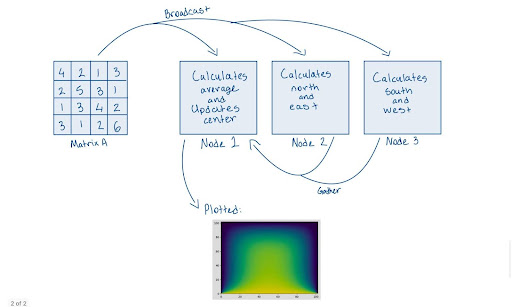

From the image above, it’s evident that when you attempt to distribute computations manually using MPI, you may encounter several challenges, such as handling synchronization and managing data gathering among nodes. These complexities can make parallel programming cumbersome and error-prone.

However, with cuPyNumeric, you can bypass these issues entirely. cuPyNumeric simplifies the process by handling synchronization and data management automatically, allowing you to focus on your computations without worrying about the underlying complexities.

## **Example/Code:**

Attached in the link below is a code along example that you can try:

[Jacobi stencil](https://docs.nvidia.com/cupynumeric/24.11/examples/stencil.html)


## **Running on CPU:**

Create a new file for our Jacobi stencil code, simply name it jacobi-stencil.py, and insert this piece of code:

In [ ]:
import argparse
import cupynumeric as np 
from legate.timing import time

def jacobi(grid, I):
    print("Running Jacobi stencil... ", end="")

    center = grid[1:-1, 1:-1]
    north = grid[0:-2, 1:-1]
    east = grid[1:-1, 2:]
    west = grid[1:-1, 0:-2]
    south = grid[2:, 1:-1]

    start = time()
    for i in range(I):
        average = center + north + east + west + south
        center[:] = 0.2 * average
    stop = time()

    print(f"Elapsed Time: {(stop - start)/1000} ms")
    
    return grid

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "-n",
        "--size",
        type=int,
        default=100,
        help="Size of the grid",
    )
    parser.add_argument(
        "-i",
        "--iterations",
        type=int,
        default=100,
        help="Number of iterations",
    )

    args = parser.parse_args()

    print(f"Generating a grid of size {args.size}x{args.size}")
    print(f"Number of iterations: {args.iterations}")

    grid = np.zeros((args.size, args.size))  
    result = jacobi(grid, args.iterations)


In order to run the following file, run the command down below, this will perform the Jacobi stencil on a grid size of 10,000 x 10,000, and the number of iterations being 100

In [ ]:
legate --cpus 1 --sysmem 16000 ./jacobi_stencil.py --size 10000 --iterations 100

Output:

In [ ]:
Generating a grid of size 10000 x 10000
Number of iterations: 100
Running Jacobi stencil... Elapsed Time: 294165.16 ms

## **Running on GPU:**

This time around we will ***increase*** the size of the grid to 15,000 x 15,000 with 100 iterations:

In [ ]:
legate --gpus 1 --sysmem 16000 --fbmem 15000 ./jacobi_stencil.py --size 15000 --iterations 100

Output:

In [ ]:
Generating a grid of size 15000x15000
Number of iterations: 100
Running Jacobi stencil... Elapsed Time: 3550.49 ms

Now let's use ***2 GPUs (1 node)*** to solve a bigger problem with a grid size of 30,000 x 30,000 with 200 iterations: 

In [ ]:
legate --gpus 2 --sysmem 16000 --fbmem 38000 ./jacobi_stencil.py --size 30000 --iterations 200

Output:

In [ ]:
Generating a grid of size 30000x30000
Number of iterations: 200
Running Jacobi stencil... Elapsed Time: 8850.259 ms

Now let's use ***4 GPUs (1 node)*** to solve a bigger problem with a grid size of 50,000 x 50,000 with 300 iterations: 

In [ ]:
legate --gpus 4 --sysmem 16000 --fbmem 38000 ./jacobi_stencil.py --size 50000 --iterations 300

Output:

In [ ]:
Generating a grid of size 50000x50000
Number of iterations: 300
Running Jacobi stencil... Elapsed Time: 17617.434 ms

# **Edge detection:**

## **Introduction:** 

Edge Detection is a method that is used to find points within an image at which the brightness changes significantly. Pointing out these sharp changes allows for determining the shapes, features, and contours of an image. This technique is fundamentally used for image processing and computer vision. 

## **Example/Code:**

Attached in the link below is a code along example that you can try:

[Edge Detection](https://docs.nvidia.com/cupynumeric/24.11/examples/edge_detection.html)

## **Running on GPU:**

Prior to running the code, run this command:

In [ ]:
conda install -c conda-forge pillow

Create a new file for our edge detection code, simply name it edge.py, and insert this piece of code:

In [ ]:
from legate.timing import time
import cupynumeric as np
from cupynumeric import ndarray
from scipy.signal import convolve

#Use if you want see images:
#from matplotlib import pyplot as plt

from PIL import Image

# Intensity varies between 0 and 255 in the image
intensity_min = 0.0
intensity_max = 255.0

def convolve_nd(array: ndarray, kernel: ndarray, mode: str = "same"):
    """
    Perform convolution on the input array with the provided kernel.

    Parameters:
        array: ndarray
            Input array corresponding to a grayscale image.
        kernel: ndarray
            Kernel to compute the gradient in x or y direction.
        mode: str
            Convolution mode. cuPyNumeric only supports the "same" mode.
            Scipy also supports "same" mode.

    Returns:
        The result of convolving the input array with the kernel.
    """
    if np.__name__ == "cupynumeric":
        return np.convolve(array, kernel, mode)
    return convolve(array, kernel, mode)

start_time = time()

# Read the image
image = Image.open("image.png").convert("L")

# Can resize the image to a larger size, for example, 4x the original size
larger_image = image.resize((image.width, image.height))

# Convert the image to a NumPy array for processing
image_np = np.array(larger_image)


# Sobel kernels for x and y derivatives
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Apply Sobel kernels to compute the gradient in x and y directions
grad_x = convolve_nd(image, kernel_x, mode="same")
grad_y = convolve_nd(image, kernel_y, mode="same")

# Compute the magnitude of the gradient (edges)
edges = np.sqrt(grad_x**2 + grad_y**2)

# Normalize the gradient to the range of intensity values
edges *= intensity_max / np.max(edges)
edges = edges.astype(int)

end_time = time()
elapsed_time = (end_time - start_time)/1000
print(f"Edge detection took {elapsed_time:.4f} ms")

# the code down below is what helps show case the images
'''
# Plot the original image and the detected edges
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Display the original image
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].set_xticks([]), axes[0].set_yticks([])

# Display the edges
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Detected Edges")
axes[1].set_xticks([]), axes[1].set_yticks([])

plt.show()
'''

Additionally, take the image down below and name it image.png (If you're connecting to a remote system like Perlmutter via SSH, you can use the scp (secure copy) command to transfer files such as images between your local machine and the remote system):

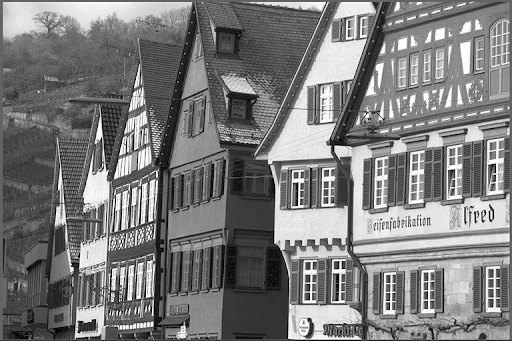

In order to run the following file, run the command down below:

In [ ]:
legate --gpus 1 --sysmem 16000 --fbmem 38000 ./edge.py

Output:

In [ ]:
Edge detection took 1083.3110 ms

If you are able to perform local, you maybe able to draw out the image using mathplotlib. The only thing you must do is possibly uncomment the line to access the library at the top and also uncomment the portion which draws the image. If done correctly, you should obtain a image which looks like this:

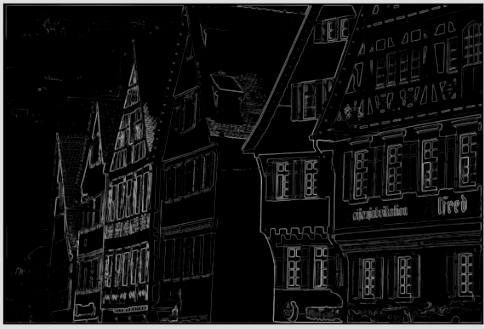

# **Resource Allocation/Utilizing Legate:**

As previously mentioned, cuPyNumeric is build on top of Legate.
Legate is what will be utilized to execute your programs. By default Legate will 
query the available hardware on the current machine, and reserve for its use all CPU
cores, all GPUs and most of the available memory. You can disable this behavior with
`LEGATE_AUTO_CONFIG=0`, then you can explicitly prescribe the resources 
used to execute your application. There are 3 different types of processors 
(task variants): CPU, GPU, and OMP (The OMP variant utilizes OpenMP threads to parallelize the 
program). In addition to specifying the processors used, you must specify the amount of memory allocated
for the program:

Possible arguments:

In [ ]:
--nodes: number of Nodes to be utilized for the program

--cpus: number of CPUs to be utilized for the program
--gpus: number of GPUs to be utilized for the program

--omps: number of OpenMP groups created
--ompthreads: number of threads in each OpenMP group

--sysmem: system memory (MB)
--fbmem: framebuffer memory per GPU (MB)

Boiler Template to run programs:

In [ ]:
#Example for CPU

legate --cpus 8 --sysmem 40000 ./main.py <main.py options>

#Example for GPU

legate --gpus 2 --fbmem 40000 ./main.py <main.py options>

#Example for OMP

legate --omps 1 --ompthreads 4 --sysmem 40000 ./main.py <main.py options>

For more information on the Command-Line Interface Options refer to [Legate CLI Options](https://docs.nvidia.com/legate/latest/usage.html#resource-allocation)

# **Best Practices:**

Start with NumPy: If you’re familiar with NumPy, you can start by writing your code as you normally would in NumPy, and then replace “import numpy as np” with “import cupynumeric as np”.

In [ ]:
import numpy as np

Becomes

In [ ]:
import cupynumeric as np

**Top 3**:

1. *Use cuPyNumeric Arrays Instead of Native Lists*  
   When using arrays, do not use the native Python data structures like lists or tuples. Create a cuPyNumeric array from these structures and operate on them using the array-based functions. 


In [ ]:
# Not recommended: Performing large-scale computation using lists
# and other native Python data structures
x = [1, 2, 3]
y = []
for val in x:
    y.append(val + 2)

# Recommended: Create a cuPyNumeric array and use array-based operations
y = np.array(x)
y = x + 2

2. *Avoid Loops with Indexing; Utilize Array-Based Operations*  
   Replace explicit loops with array-based implementations, If a component of the array needs to be set/updated  

In [ ]:
# Example 1
# x and y are three-dimensional arrays

# Not recommended: Naive element-wise implementation
for i in range(ny):
    for j in range(nx):
        x[0, j, i] = y[3, j, i]

# Recommended: Array-based implementation
x[0] = y[3]

# Example 2

# x and y are two-dimensional arrays, and we need to update x
# depending on whether y meets a condition or not.

# Not recommended: Naive element-wise implementation
for i in range(ny):
    for j in range(nx):
        if (y[j, i] < tol):
            x[j, i] = const
        else
            x[j, i] = 1.0 - const

# Recommended: Array-based implementation
cond = y < tol
x[cond] = const
x[~cond] = 1.0 - const

3. *Use boolean masks, AVOID advanced indexing*  
   Indexing the array using a boolean mask will be faster than using an array with indices 

In [ ]:
import cupynumeric as np

# Not recommended: don't use nonzero to get indices
indices = np.nonzero(h < 0)
x[indices] = y[indices]

# Recommended: Use boolean mask to update the array
cond = h < 0
x[cond] = y[cond]

For more best practices, go to cuPyNumeric [Best Practices](https://docs.nvidia.com/cupynumeric/24.11/user/practices.html)!